In [27]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [28]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, MCMC, Predictive
from pyro.infer.mcmc import NUTS
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from src import generate, train, eval
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader
from modules.bnn_model import BayesianNN, NormalPrior, GaussianLikelihood
from modules.mcmc_bnn import MCMC_BNN

In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

In [5]:
dataset_config["TRAIN_SIZE"] = "100"
dataset_config["TEST_SIZE"] = "100"
dataset_config["SIGMA"] = "0.3"

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -1.4279431423488806 - 1.5602615588548145
In Domain: (-10, 10)
Y-space: -1.5728629001484995 - 1.5151104079718951
Out Domain: (-20, 20)
Y-space: -1.5110794057988066 - 1.4468968173085783


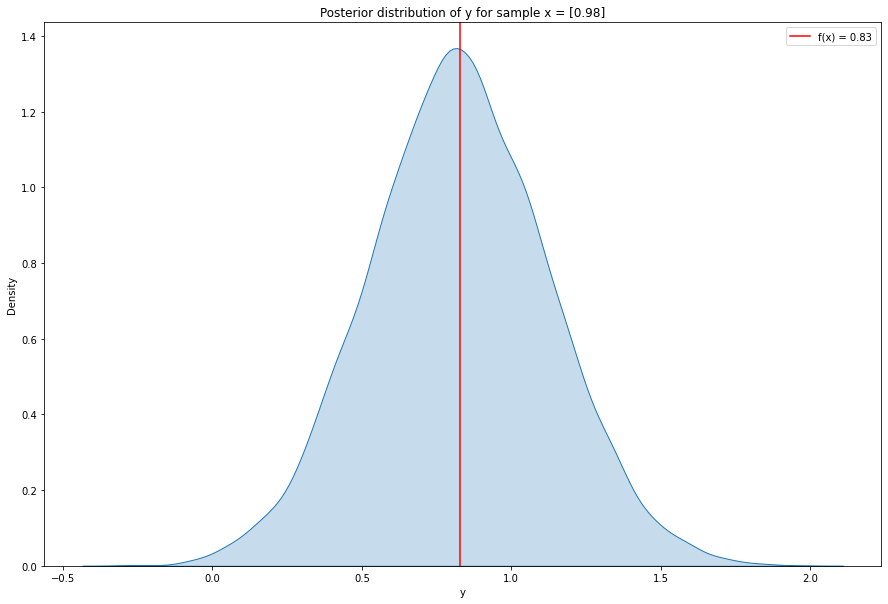

In [6]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [7]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test, y_test = torch.vstack((x_test_in_domain, x_test_out_domain)), torch.vstack((y_test_in_domain, y_test_out_domain))

In [8]:
x_train.shape, y_train.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [9]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [10]:
x, y = next(iter(train_dataloader))

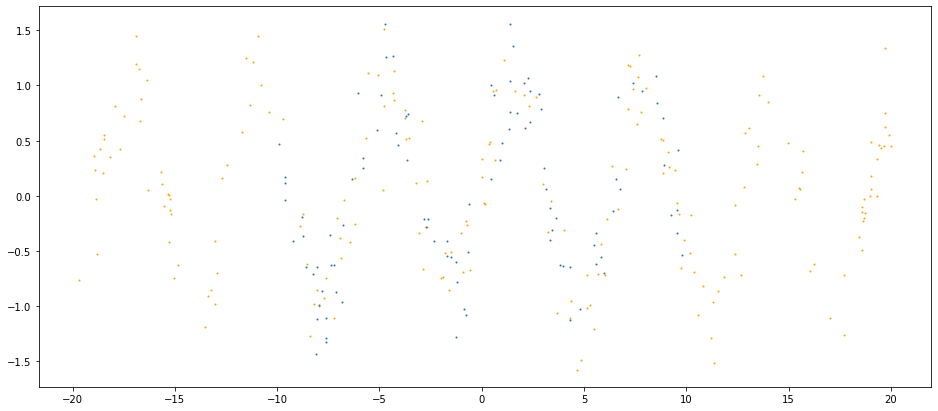

In [11]:

test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)

In [12]:
prior = NormalPrior(0, 1)
likelihood = GaussianLikelihood(dist.Gamma(1.0, 1.0), len(x_train))
model = BayesianNN(1, 1, prior, hidden_features=[], device="cpu")
model

BayesianNN(
  (fc0): BayesianLayer(
    (linear): PyroLinear(in_features=1, out_features=1, bias=True)
  )
)

In [13]:
kernel_builder = NUTS
mcmc_bnn = MCMC_BNN(model, likelihood, kernel_builder, device="cpu")

In [14]:
mcmc_bnn.fit(train_dataloader, num_samples=300, num_warmup=100, num_chains=5)

Warmup [1]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/400 [00:00, ?it/s]

In [15]:
with poutine.trace() as tr:
    #mcmc_bnn._model(x_test)
    mcmc_bnn.likelihood.get_scale()
tr.trace.nodes.keys()

odict_keys(['likelihood._scale'])

In [16]:
mcmc_bnn._mcmc.get_samples()["likelihood._scale"]

tensor([0.7102, 0.7123, 0.7123,  ..., 0.8153, 0.6589, 0.7718])

In [17]:
tr.trace.nodes["likelihood._scale"]

{'type': 'sample',
 'name': 'likelihood._scale',
 'fn': Gamma(concentration: 1.0, rate: 1.0),
 'is_observed': False,
 'args': (),
 'kwargs': {},
 'value': tensor(2.0792),
 'infer': {},
 'scale': 1.0,
 'mask': None,
 'cond_indep_stack': (),
 'done': True,
 'stop': False,
 'continuation': None}

In [18]:
x_samps = x_test[:5]
preds = mcmc_bnn.predict(x_samps, num_predictions=100, aggregate=False)

tensor([0.7320, 0.6683, 0.6581, 0.7748, 0.7681, 0.9465, 0.7363, 0.8038, 0.7128,
        0.7055, 0.8399, 0.7312, 0.7271, 0.6780, 0.7509, 0.7312, 0.7284, 0.7523,
        0.6879, 0.6911, 0.7810, 0.7005, 0.7484, 0.7607, 0.7242, 0.7092, 0.7128,
        0.7505, 0.7222, 0.6979, 0.8060, 0.8064, 0.6821, 0.7159, 0.7439, 0.6989,
        0.6846, 0.6994, 0.7555, 0.8114, 0.6579, 0.8022, 0.7993, 0.7262, 0.7587,
        0.7681, 0.8476, 0.7423, 0.7440, 0.7061, 0.7300, 0.7611, 0.7103, 0.8411,
        0.7474, 0.7092, 0.7308, 0.7158, 0.7734, 0.7316, 0.6611, 0.6768, 0.6845,
        0.6537, 0.7748, 0.7418, 0.8129, 0.7119, 0.6578, 0.7558, 0.6924, 0.7636,
        0.7665, 0.7782, 0.8293, 0.7765, 0.7066, 0.6784, 0.6910, 0.8443, 0.7836,
        0.8589, 0.6296, 0.8578, 0.6849, 0.7565, 0.6688, 0.6773, 0.7175, 0.6434,
        0.7354, 0.7448, 0.7427, 0.7382, 0.7667, 0.7516, 0.7795, 0.7174, 0.8441,
        0.7904])
tensor([0.7320, 0.6683, 0.6581, 0.7748, 0.7681, 0.9465, 0.7363, 0.8038, 0.7128,
        0.7055, 0.8399,

In [19]:
preds.mean(dim=0)

tensor([[ 0.2951],
        [-0.1040],
        [-0.1649],
        [-0.0742],
        [-0.1053]])

In [20]:
train_sort = torch.argsort(x_train.squeeze())
preds = mcmc_bnn.predict(x_train[train_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

tensor([0.7197, 0.7175, 0.8325, 0.7158, 0.7181, 0.7425, 0.7441, 0.6688, 0.8703,
        0.6720, 0.6730, 0.7024, 0.8202, 0.7587, 0.6991, 0.8485, 0.8397, 0.7904,
        0.7100, 0.7617, 0.8174, 0.6366, 0.6607, 0.6942, 0.7206, 0.6672, 0.7552,
        0.8063, 0.7243, 0.7131, 0.7224, 0.7659, 0.7683, 0.9103, 0.6567, 0.8298,
        0.7011, 0.7178, 0.7228, 0.6365, 0.7067, 0.7804, 0.7718, 0.7768, 0.7176,
        0.7448, 0.7832, 0.7125, 0.6893, 0.7768, 0.7554, 0.7618, 0.6567, 0.7239,
        0.7548, 0.7134, 0.7187, 0.7220, 0.7644, 0.7176, 0.7017, 0.7308, 0.7637,
        0.6994, 0.6963, 0.6189, 0.6594, 0.6627, 0.8741, 0.7351, 0.6653, 0.8228,
        0.7444, 0.7321, 0.7142, 0.7460, 0.7229, 0.7187, 0.6974, 0.7446, 0.7351,
        0.7197, 0.7185, 0.6932, 0.6667, 0.7792, 0.7162, 0.7521, 0.7994, 0.7295,
        0.6956, 0.6727, 0.7718, 0.7017, 0.7624, 0.7382, 0.6924, 0.7050, 0.7453,
        0.7257, 0.5967, 0.6766, 0.7336, 0.7907, 0.6886, 0.7811, 0.7311, 0.7665,
        0.7321, 0.7639, 0.7446, 0.8430, 

In [21]:
stds

tensor([[0.7473],
        [0.7468],
        [0.7467],
        [0.7467],
        [0.7460],
        [0.7453],
        [0.7452],
        [0.7450],
        [0.7445],
        [0.7443],
        [0.7442],
        [0.7442],
        [0.7440],
        [0.7438],
        [0.7436],
        [0.7436],
        [0.7435],
        [0.7433],
        [0.7432],
        [0.7430],
        [0.7429],
        [0.7425],
        [0.7424],
        [0.7419],
        [0.7416],
        [0.7413],
        [0.7413],
        [0.7406],
        [0.7405],
        [0.7403],
        [0.7403],
        [0.7400],
        [0.7399],
        [0.7398],
        [0.7395],
        [0.7395],
        [0.7395],
        [0.7391],
        [0.7390],
        [0.7390],
        [0.7389],
        [0.7387],
        [0.7387],
        [0.7386],
        [0.7386],
        [0.7386],
        [0.7386],
        [0.7386],
        [0.7386],
        [0.7386],
        [0.7385],
        [0.7386],
        [0.7386],
        [0.7387],
        [0.7388],
        [0

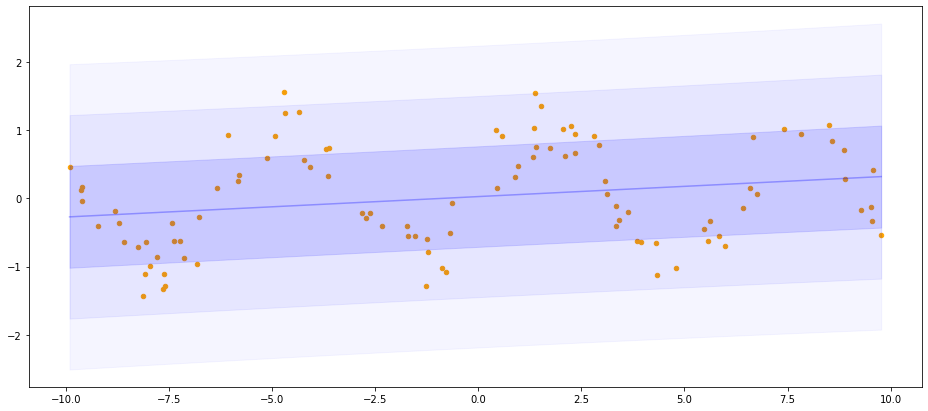

In [22]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="orange", s=20, alpha=1.0)
plt.plot(x_train[train_sort], means, color="blue", alpha=0.3)
for c in range(1, 4):
    plt.fill_between(x_train[train_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

In [23]:
test_sort = torch.argsort(x_test.squeeze())
preds = mcmc_bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

tensor([0.7558, 0.7881, 0.6948, 0.7650, 0.8628, 0.7905, 0.6726, 0.7763, 0.7423,
        0.7918, 0.6664, 0.6740, 0.7427, 0.7117, 0.6594, 0.7329, 0.6994, 0.6935,
        0.7782, 0.7474, 0.7750, 0.6655, 0.7975, 0.6520, 0.7403, 0.7765, 0.7436,
        0.6726, 0.7826, 0.7413, 0.6860, 0.7039, 0.7586, 0.7809, 0.7412, 0.7103,
        0.8221, 0.8279, 0.7581, 0.7433, 0.8063, 0.7369, 0.7011, 0.7765, 0.6681,
        0.6831, 0.7092, 0.7535, 0.9158, 0.6521, 0.8975, 0.7399, 0.7965, 0.7565,
        0.6984, 0.7498, 0.8730, 0.8042, 0.7092, 0.7980, 0.7469, 0.6631, 0.7381,
        0.7902, 0.7599, 0.6664, 0.8384, 0.6598, 0.6614, 0.8206, 0.7824, 0.6672,
        0.7492, 0.7565, 0.7890, 0.7976, 0.7665, 0.7555, 0.7770, 0.7474, 0.7808,
        0.6923, 0.7929, 0.7702, 0.7493, 0.7881, 0.7498, 0.7289, 0.7249, 0.6683,
        0.6508, 0.7633, 0.6475, 0.7935, 0.6667, 0.7461, 0.7248, 0.6910, 0.7117,
        0.7665, 0.6295, 0.7233, 0.6902, 0.7439, 0.8017, 0.6296, 0.8085, 0.6963,
        0.7167, 0.6670, 0.7876, 0.6910, 

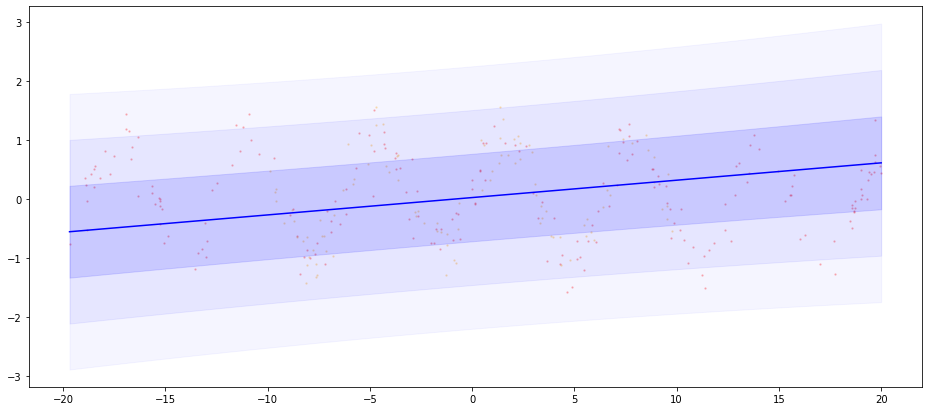

In [24]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

tensor([0.7565, 0.8114, 0.6948, 0.7326, 0.7517, 0.7668, 0.7303, 0.6932, 0.7139,
        0.6821, 0.7354, 0.7165, 0.7074, 0.7301, 0.7651, 0.7593, 0.7583, 0.7060,
        0.7353, 0.7772, 0.8039, 0.8038, 0.9184, 0.7045, 0.8192])
tensor([0.7565, 0.8114, 0.6948, 0.7326, 0.7517, 0.7668, 0.7303, 0.6932, 0.7139,
        0.6821, 0.7354, 0.7165, 0.7074, 0.7301, 0.7651, 0.7593, 0.7583, 0.7060,
        0.7353, 0.7772, 0.8039, 0.8038, 0.9184, 0.7045, 0.8192])


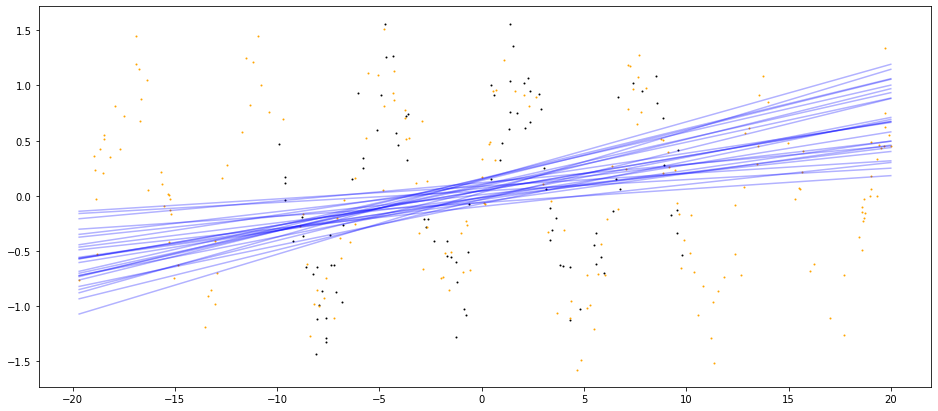

In [25]:


sampled_predictions = mcmc_bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [26]:
bnn.get_error_metrics(x_train, y_train, num_predictions=100, reduction="mean")

NameError: name 'bnn' is not defined